In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import sunode.wrappers.as_pytensor
import sunode
import pymc as pm
import arviz as az
from scipy.integrate import odeint

In [2]:
data = pd.read_csv('CovidData.csv')

In [3]:
data.head()

,Dates,Total Cases,Daily New Cases,Active Cases,Total Deaths,Daily Deaths,New Recoveries
0,"Feb 15, 2020",3,0,0,0,0,0
1,"Feb 16, 2020",3,0,0,0,0,0
2,"Feb 17, 2020",3,0,0,0,0,0
3,"Feb 18, 2020",3,0,0,0,0,0
4,"Feb 19, 2020",3,0,0,0,0,0


In [4]:
N = 1366417754 #Population at 2019

In [5]:
I = data.loc[:, "Active Cases"]
R = data.loc[:, "New Recoveries"].cumsum()
S = N - I - R
X = data.loc[:, "Dates"]

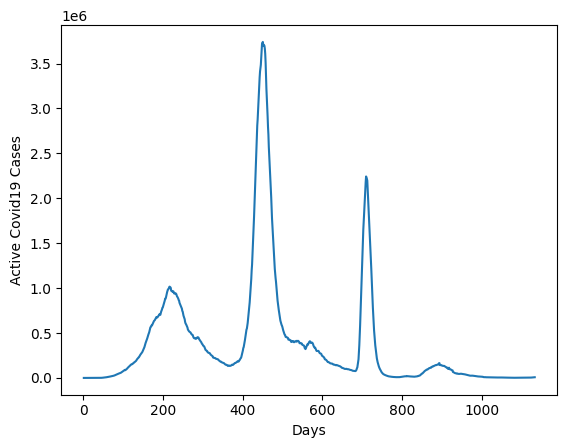

In [6]:
plt.plot(np.linspace(1, len(I) + 1, len(I)), I)
plt.xlabel("Days")
plt.ylabel("Active Covid19 Cases")
plt.show()

In [7]:
S_new = np.array(S[800:]) / N 
R_new = np.array(R[800:])
I_new = np.array(I[800:])
S_start = S[799] / N
I_start = I[799]
R_start = R[799]
times = np.arange(1, len(S_new) + 1)

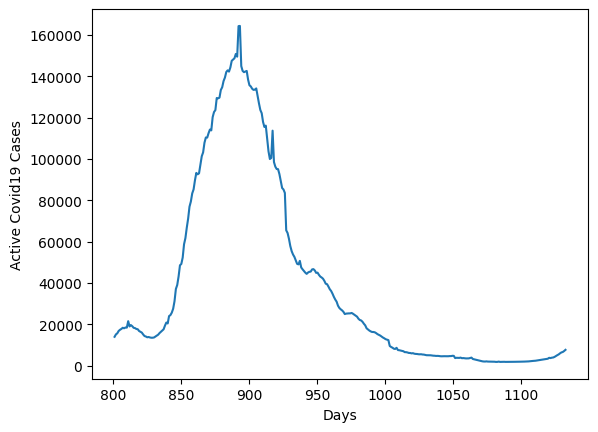

In [8]:
plt.plot(np.linspace(801, len(I_new) + 801, len(I_new)), I_new)
plt.xlabel("Days")
plt.ylabel("Active Covid19 Cases")
plt.show()

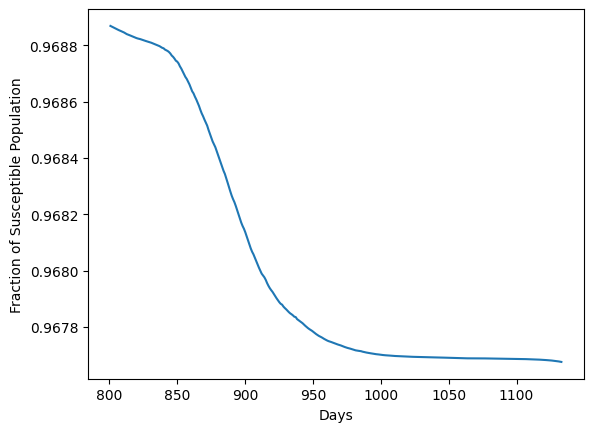

In [9]:
plt.plot(np.linspace(801, len(S_new) + 801, len(S_new)), S_new)
plt.xlabel("Days")
plt.ylabel("Fraction of Susceptible Population")
plt.show()

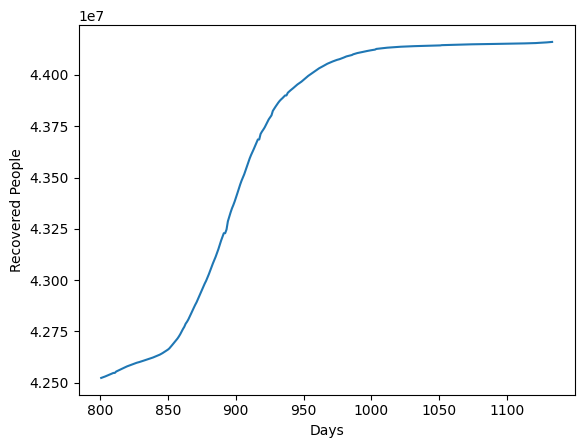

In [10]:
plt.plot(np.linspace(801, len(R_new) + 801, len(R_new)), R_new)
plt.xlabel("Days")
plt.ylabel("Recovered People")
plt.show()

In [11]:
def sir_sunode(t, y, p):
    return {
            'S': -p.beta * y.S * y.I / p.N,
            'I': p.beta * y.S * y.I - p.gamma * y.I,
            #'R': p.gamma * y.I
    }

In [12]:
lib = sunode._cvodes.lib
with pm.Model() as model:
    beta = pm.LogNormal("beta", np.log(0.4), 0.5)
    gamma = pm.LogNormal("gamma", np.log(0.125), 0.2)

    y_hat, _, problem, solver, _, _ = sunode.wrappers.as_pytensor.solve_ivp(
        y0={
            'S': (S_start, ()),
            'I': (I_start, ()),
            #'R': (R_start, ()),
        },
        params={
            'beta': (beta, ()),
            'gamma': (gamma, ()),
            'N': (N, ()),
        },
        rhs=sir_sunode,
        tvals=times,
        t0=times[0],
    )
    lib.CVodeSStolerances(solver._ode, 1e-8, 1e-8)
    y_hat_clip = pm.math.clip(y_hat["I"], 1, 1366417754)
    pm.Poisson('I', mu = y_hat_clip, observed = I_new, shape = (len(I_new)))

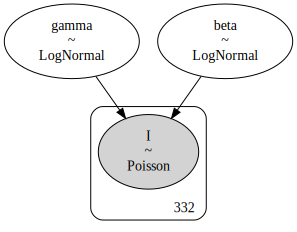

In [13]:
pm.model_to_graphviz(model=model)

In [14]:
# Variable list to give to the sample step parameter
vars_list = list(model.values_to_rvs.keys())[:-1]

In [15]:
with model:
    trace = pm.sample(draws = 20000, chains=4, progressbar=True, random_seed = 0, cores = 4, step = [pm.DEMetropolisZ(vars_list, proposal_dist= pm.NormalProposal)])
az.summary(trace)

Multiprocess sampling (4 chains in 4 jobs)
DEMetropolisZ: [beta, gamma]


/anaconda/envs/sunode-env/lib/python3.10/site-packages/pymc/step_methods/metropolis.py:990: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/anaconda/envs/sunode-env/lib/python3.10/site-packages/pymc/step_methods/metropolis.py:990: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/anaconda/envs/sunode-env/lib/python3.10/site-packages/pymc/step_methods/metropolis.py:990: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/anaconda/envs/sunode-env/lib/python3.10/site-packages/pymc/step_methods/metropolis.py:990: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
Sampling 4 chains for 1_000 tune and 20_000 draw iterations (4_000 + 80_000 draws total) took 61 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher n

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta,2.781,0.001,2.78,2.782,0.0,0.0,216.0,189.0,1.01
gamma,2.660,0.001,2.66,2.661,0.0,0.0,214.0,190.0,1.01


array([[<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'gamma'}>,
        <Axes: title={'center': 'gamma'}>]], dtype=object)

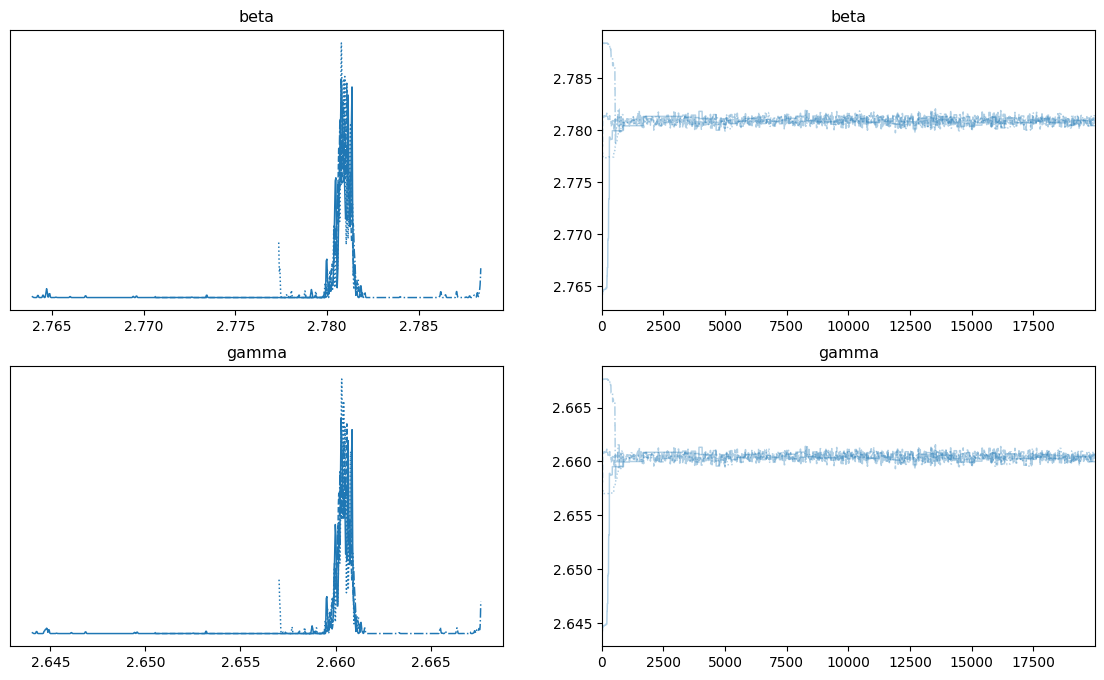

In [16]:
az.plot_trace(trace, figsize = (14, 8))

array([<Axes: title={'center': 'beta'}>,
       <Axes: title={'center': 'gamma'}>], dtype=object)

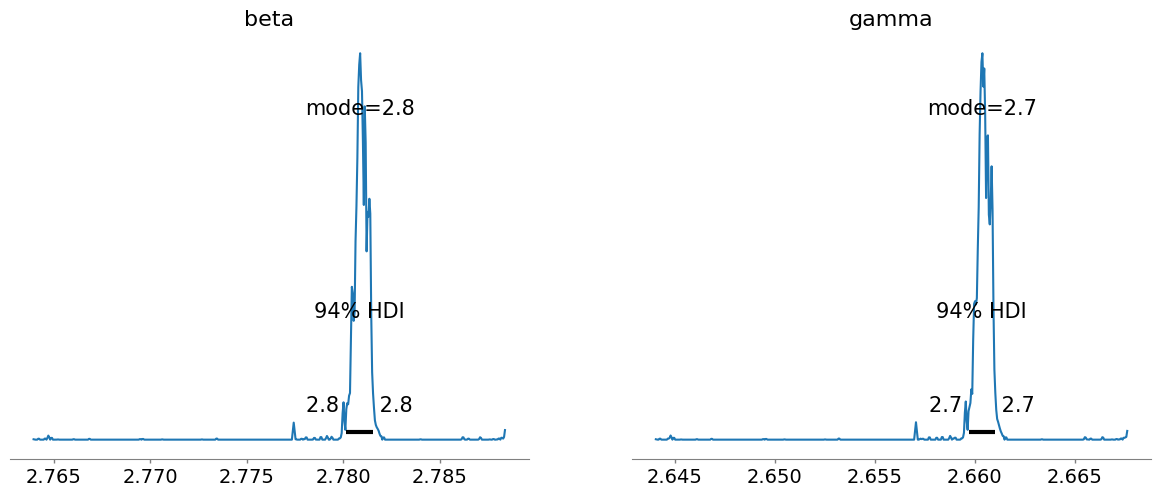

In [17]:
az.plot_posterior(trace, round_to=2, point_estimate="mode")

In [18]:
trace.to_netcdf("trace.nc")

'trace.nc'

In [19]:
burn_in = 2500
burned_trace = trace.sel(draw=slice(burn_in, None), groups="posterior")

In [20]:
az.summary(burned_trace, stat_focus="mean")

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta,2.781,0.0,2.78,2.782,0.0,0.0,283.0,574.0,1.02
gamma,2.660,0.0,2.66,2.661,0.0,0.0,274.0,543.0,1.02


array([[<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'gamma'}>,
        <Axes: title={'center': 'gamma'}>]], dtype=object)

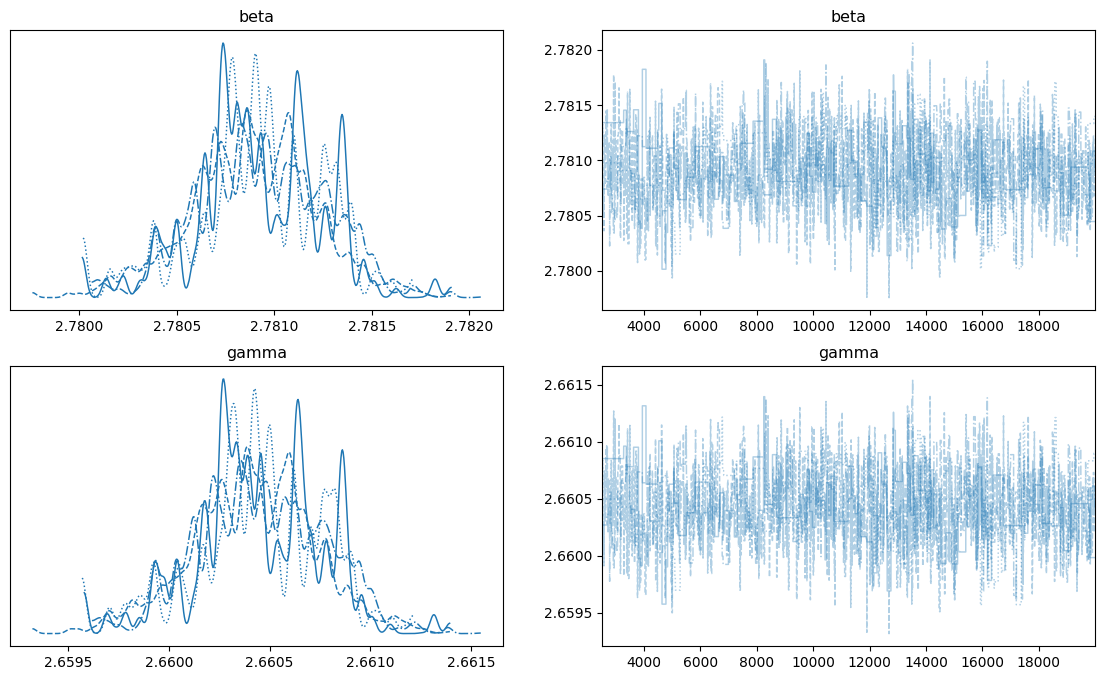

In [21]:
az.plot_trace(burned_trace, figsize = (14, 8))

array([<Axes: title={'center': 'beta'}>,
       <Axes: title={'center': 'gamma'}>], dtype=object)

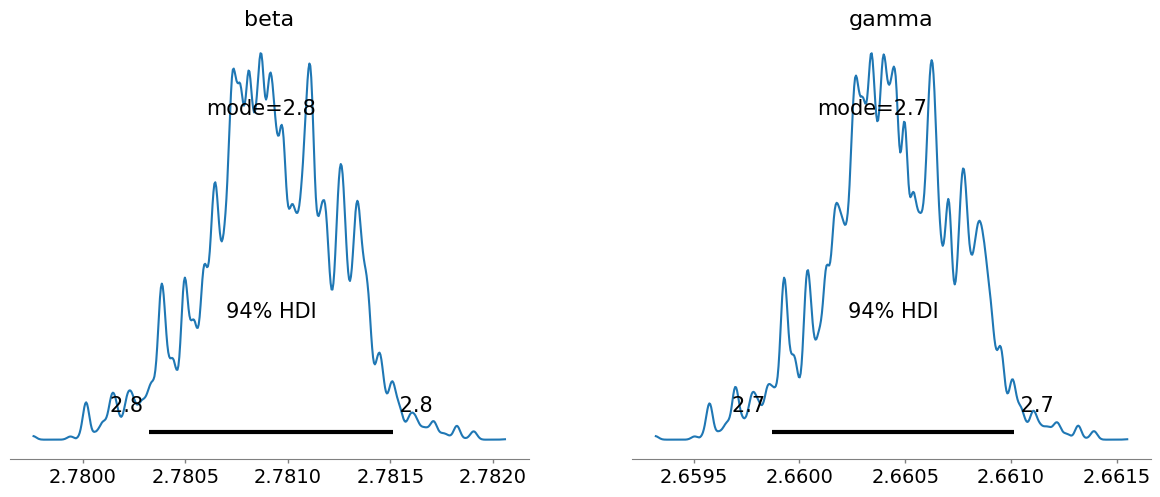

In [22]:
az.plot_posterior(burned_trace, round_to=2, point_estimate="mode")

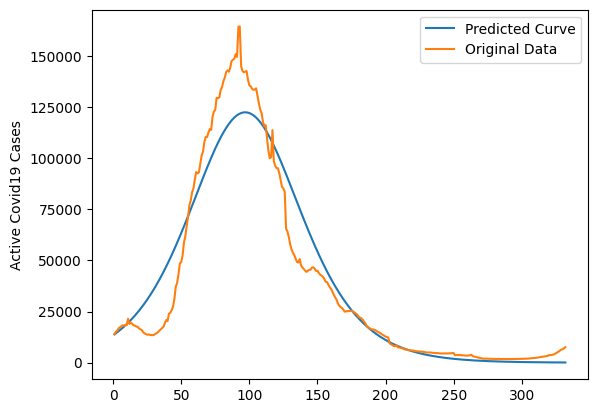

In [23]:
beta, gamma = 2.781, 2.660

def deriv(y, t, N, beta, gamma):
    S, I = y
    dSdt = -beta * S * I / N
    dIdt = (beta * S * I) - (gamma * I)
    return dSdt, dIdt

y0 = S_start, I_start

ret = odeint(deriv, y0, times, args=(N, beta, gamma), atol = 1e-6, rtol = 1e-6)
I_predicted = ret[:, 1]

plt.plot(times, I_predicted, label = "Predict")
plt.plot(times, I_new, label = "Data")
plt.ylabel("Active Covid19 Cases")

plt.legend(["Predicted Curve", "Original Data"])
plt.show()

In [24]:
I_March_22 = I_new[-1]
print(I_March_22)

7605


In [25]:
#R0 = beta / gamma
R0 = 2.781 / 2.660

In [26]:
Predicted_I_March_23 = I_March_22 * R0
print(Predicted_I_March_23)
#Actual Infected cases on March 23 = 7927

7950.941729323308
